In [1]:
#!/usr/bin/env python3
import sys
srcdir = "/project/mchaisso_100/cmb-16/tsungyul/work/vntr/danbing-tk/script/"
sys.path.insert(0, srcdir)

In [2]:
import numpy as np
import pandas as pd
import vntrutils as vu
import utils
# import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
# %load_ext autoreload
# %autoreload 2

In [3]:
from collections import defaultdict
import pickle
# import networkx as nx
# import pygraphviz
# import collections
import gc
import glob
# import warnings
import statsmodels.api as sm
# from statsmodels.stats.multitest import fdrcorrection as fdr
# from scipy import stats
import gzip
# from sklearn.decomposition import PCA
# from scipy.stats import chi2
# import re
# import json

In [4]:
matplotlib.rc('font', size=7)
matplotlib.rc('axes', titlesize=7)
matplotlib.rc('xtick', labelsize=5)
matplotlib.rc('ytick', labelsize=5)
%load_ext autoreload
%autoreload 2

# IL dosage

In [5]:
def test():
    fn = "/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/clinic/cdbg/v1/ks.ccks.cck_ns.ki_map.pickle"
    with open(fn, 'rb') as f:
        ks, ccks, cck_ns, ki_map = pickle.load(f)
    print(len(ks), len(ccks))
    return ki_map
ki_map = test()

62457731 4456881


In [7]:
def load_single_gt(fn, gt, i):
    with open(fn) as f:
        j = 0
        for line in f:
            gt[i,j] = int(line)
            j += 1
    
def compute_gt_cgt_batch():
    kmerfs = sorted(glob.glob("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/output/*.tr.kmers"))
    ng = len(kmerfs)
    fn = "/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/clinic/cdbg/v1/ks.ccks.cck_ns.ki_map.pickle"
    with open(fn, 'rb') as f:
        ks, ccks, cck_ns, ki_map = pickle.load(f)
    nk = len(ks)
    ncck = len(ccks)
    print(ng, nk, ncck)
    cck_ns = np.array(cck_ns)
    tr_cck_ns = np.zeros(ncck, dtype=int)
    for i0 in range(nk):
        tr_cck_ns[ki_map[i0]] += 1
    
    NB = 1
    BS = ng // NB
    for i in range(NB):
        BS_ = BS if i != NB-1 else ng - BS*i
        print(f"batch {i}: loading gt... ", end="")
        gt = np.zeros([BS_, nk], dtype=np.int32)
        for j in range(BS_):
            load_single_gt(kmerfs[i*BS+j], gt, j)
        print(f"computing cgt... ", end="")
        cgt = np.zeros([BS_,ncck], dtype=np.float32)
        for i0, i1 in ki_map.items():
            cgt[:,i1] += gt[:,i0]
        print(pd.DataFrame(cgt))
        cgt /= tr_cck_ns
        print("dumping gt... ", end="")
        with open(f"/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/gt_pickle/gt.{i}.pickle", 'wb') as f:
            pickle.dump(gt, f, protocol=pickle.HIGHEST_PROTOCOL)
        print("dumping cgt...")
        with open(f"/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/gt_pickle/cgt.{i}.pickle", 'wb') as f:
            pickle.dump(cgt, f, protocol=pickle.HIGHEST_PROTOCOL)

!mkdir -p /project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/gt_pickle
compute_gt_cgt_batch()

36 62457731 4456881
batch 0: loading gt... computing cgt...     0        1        2        3        4        5        6        7        \
0    1293.0    671.0   1000.0   1750.0   1149.0      0.0    235.0      0.0   
1    1222.0   1283.0   1172.0   2269.0   1344.0      0.0    371.0     93.0   
2    1404.0    515.0    943.0   1919.0   1083.0      0.0    335.0    173.0   
3    1187.0    789.0    990.0   1757.0   1113.0      1.0    293.0    155.0   
4    1459.0    633.0   1045.0   1666.0   1252.0      0.0    547.0     46.0   
5    1486.0    791.0   1149.0   1975.0   1369.0      0.0    616.0     84.0   
6    1119.0    654.0    790.0   1596.0    916.0      0.0    359.0     57.0   
7    1727.0    390.0   1116.0   1903.0   1290.0      0.0    420.0     84.0   
8    1468.0    835.0   1110.0   2056.0   1157.0      0.0    326.0     61.0   
9    1042.0    798.0    947.0   1635.0   1076.0      0.0    329.0     81.0   
10   1317.0    736.0   1004.0   1794.0   1149.0      0.0    359.0    218.0   
11  

In [7]:
def test():
    # correct coverage and X chrom dosage
    genomes = np.loadtxt("/project/mchaisso_100/cmb-16/tsungyul/work/vntr/hapdb/config/genomes.HPRC.notinHGSVC.hasIL.src.txt", usecols=1, dtype=object)
    ng = genomes.size
    g2i = dict([[g,i] for i, g in enumerate(genomes)])
    cov = np.array([float(c) for g, c in np.loadtxt("/project/mchaisso_100/cmb-17/vntr_genotyping/analysis/read_depth/ctrl/HPRC.notinHGSVC.chr1.cov.tsv", dtype=object) if g in genomes])
    sex = np.zeros(cov.size, dtype=int)
    sex2i = {"female":2, "male":1}
    for g, v1 in np.loadtxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/input/sample.meta.txt", skiprows=1, usecols=[0,1], dtype=object):
        if g in g2i:
            sex[g2i[g]] = sex2i[v1]
    print("Loading cgt", end="")
    NCCK = 4456881
    NB = 1
    BS = ng//NB
    cgt = np.zeros([ng,NCCK], dtype=np.float32)
    for i in range(NB):
        print(f".",end="")
        BS_ = BS if i != NB-1 else ng - BS*i
        with open(f"/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/gt_pickle/cgt.{i}.pickle", 'rb') as f:
            si = i*BS
            ei = i*BS + BS_
            cgt[si:ei] = pickle.load(f)
    print()
    print("Computing acgt")
    with open("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/clinic/cdbg/v1/ki_tr.ccki_tr.pickle", 'rb') as f:
        _, ccki_tr = pickle.load(f)
    acgt = np.zeros_like(cgt, dtype=np.float32)
    ai = ccki_tr[NAU-1]
    acgt[:,:ai] = cgt[:,:ai] / cov[:,None]
    acgt[:,ai:] = cgt[:,ai:] / (cov * sex)[:,None]
    print("Dumping acgt")
    with open("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/gt_pickle/acgt.pickle", 'wb') as f:
        pickle.dump(acgt, f, protocol=pickle.HIGHEST_PROTOCOL)
    return acgt

ilcgt = test()

Loading cgt.
Computing acgt
Dumping acgt


In [6]:
ilcgt =  pickle.load(open("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/gt_pickle/acgt.pickle", 'rb'))

In [6]:
ilcgt.shape

(36, 4456881)

In [20]:
def test():
    with open(f"/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/gt_pickle/gt.0.pickle", 'rb') as f:
        gt = pickle.load(f)
    genomes = np.loadtxt("/project/mchaisso_100/cmb-16/tsungyul/work/vntr/hapdb/config/genomes.HPRC.notinHGSVC.hasIL.src.txt", usecols=1, dtype=object)
    cov = np.array([float(c) for g, c in np.loadtxt("/project/mchaisso_100/cmb-17/vntr_genotyping/analysis/read_depth/ctrl/HPRC.notinHGSVC.chr1.cov.tsv", dtype=object) if g in genomes])
    agt = gt / cov[:,None]
    with open("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/gt_pickle/agt.pickle", 'wb') as f:
        pickle.dump(agt, f, protocol=pickle.HIGHEST_PROTOCOL)
    return agt
# ilgt = test()

In [27]:
ilgt =  pickle.load(open("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/gt_pickle/agt.pickle", 'rb'))

In [21]:
ilgt.shape

(36, 62457731)

# PB dosage

In [12]:
def test():
    tri2km2i = {}
    with open("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/clinic/cdbg/v1/pan.reindex_as_output.tr.kmers") as f:
        tri = -1
        ki = -1
        for line in f:
            if line[0] == ">":
                tri += 1
                tri2km2i[tri] = {}
            else:
                ki += 1
                tri2km2i[tri][int(line.rstrip())] = ki
    return tri2km2i
tri2km2i = test()

In [7]:
def test():
    with open("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/clinic/cdbg/v1/ki_tr.ccki_tr.pickle", 'rb') as f:
        ki_tr, _ = pickle.load(f)
    return ki_tr
ki_tr = test()

In [8]:
def test():
    fn = "/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/clinic/cdbg/v1/ks.ccks.cck_ns.ki_map.pickle"
    with open(fn, 'rb') as f:
        ks, ccks, cck_ns, ki_map = pickle.load(f)
    return ks, ccks, cck_ns, ki_map
ks, ccks, cck_ns, ki_map = test()

In [9]:
def test():
    with open("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/clinic/cdbg/v1/ki_tr.ccki_tr.pickle", 'rb') as f:
        _, ccki_tr = pickle.load(f)
    return ccki_tr
ccki_tr = test()

In [16]:
def test():
    with open("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/clinic/cdbg/v1/tr_cck_ns.pickle", 'rb') as f:
        tr_cck_ns = pickle.load(f)
    return tr_cck_ns
tr_cck_ns = test()

In [10]:
# generate hprc_in_hgsvc.uniq_map.final.bed
# !/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/analysis/gen.uniq_overlap_bed.sh
def test():
    i1i0 = np.loadtxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/analysis/hprc_in_hgsvc.uniq_map.final.v1.bed", usecols=[3,4], dtype=int)
    tri021, tri120 = {}, {}
    for i1, i0 in i1i0:
        tri021[i0] = i1
        tri120[i1] = i0
    return tri021, tri120
tri021, tri120 = test()

In [26]:
def test():
    NK = len(ks)
    ng, NCCK = ilgt.shape
    pbgt = np.zeros([ng,NK], dtype=np.int32)
    for gi, gn in enumerate(np.loadtxt("/project/mchaisso_100/cmb-16/tsungyul/work/vntr/hapdb/config/genomes.HPRC.notinHGSVC.hasIL.src.txt", usecols=1, dtype=object)):
        print(".", end="")
        with open(f"/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/output/{gn}.rawPB.tr.kmers") as f:
            tri = -1
            skip = True
            for line in f:
                if line[0] == ">":
                    tri += 1
                    if tri in tri120:
                        tri0 = tri120[tri]
                        skip = False
                    else:
                        skip = True
                else:
                    if not skip:
                        km, ct = [int(v) for v in line.split()]
                        if km in tri2km2i[tri0]:
                            ki = tri2km2i[tri0][km]
                            pbgt[gi,ki] = ct
    with open("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/gt_pickle/pbgt.pickle", 'wb') as f:
        pickle.dump(pbgt, f, protocol=pickle.HIGHEST_PROTOCOL)
# test()

In [27]:
def test():
    ng, NCCK = ilgt.shape
    with open("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/gt_pickle/pbgt.pickle", 'rb') as f:
        pbgt = pickle.load(f)
    pbcgt = np.zeros([ng,NCCK], dtype=np.float32)
    for i0, i1 in ki_map.items():
        pbcgt[:,i1] += pbgt[:,i0]
    pbcgt /= tr_cck_ns
    with open("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/gt_pickle/pbcgt.pickle", 'wb') as f:
        pickle.dump(pbcgt, f, protocol=pickle.HIGHEST_PROTOCOL)
# test()

In [28]:
def test():
    with open("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/gt_pickle/pbgt.pickle", 'rb') as f:
        pbgt = pickle.load(f)
    return pd.DataFrame(pbgt)
test()

,0,1,2,3,4,5,6,7,8,9,...,62457721,62457722,62457723,62457724,62457725,62457726,62457727,62457728,62457729,62457730
0,0,0,0,2,2,2,0,2,2,2,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,2,2,2,0,2,2,2,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,2,2,2,0,2,2,2,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,2,2,2,0,2,2,2,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,2,2,2,0,2,2,2,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,2,2,2,0,2,2,2,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,2,2,2,0,2,2,2,...,0,0,0,0,0,0,0,0,0,0
7,1,1,1,1,2,2,1,2,1,1,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,2,2,2,0,2,2,2,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,2,2,2,0,2,2,2,...,0,0,0,0,0,0,0,0,0,0


In [11]:
def test():
    with open("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/gt_pickle/pbcgt.pickle", 'rb') as f:
        pbcgt = pickle.load(f)
    return pbcgt
pbcgt = test()
pd.DataFrame(pbcgt)

,0,1,2,3,4,5,6,7,8,9,...,4456871,4456872,4456873,4456874,4456875,4456876,4456877,4456878,4456879,4456880
0,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,2.00,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,2.00,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.705882,0.0,...,0.0,2.00,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,2.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,2.00,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# batch-$r^2$

In [12]:
def get_ki(tri):
    si = ki_tr[tri-1] if tri else 0
    ei = ki_tr[tri]
    return si, ei
def get_ccki(tri):
    si = ccki_tr[tri-1] if tri else 0
    ei = ccki_tr[tri]
    return si, ei

In [13]:
i1i0 = np.loadtxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/analysis/hprc_in_hgsvc.uniq_map.final.v1.bed", usecols=[3,4], dtype=int)

## motif

In [14]:
mtfilter = np.all(np.loadtxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/clinic/analysis/mape.invariant.flank.alu.mismap_1.r2.v2.filter.tsv.gz", usecols=[3,4,5,6,7,8,9], dtype=bool, skiprows=1), axis=1)

In [15]:
np.sum(mtfilter), mtfilter.size

(769616, 4456881)

In [16]:
def test():
    omap1 = pd.read_csv("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/output/OrthoMap.v2.tsv", sep="\t", header=None, na_values=".").values
    
    gs = np.loadtxt("/project/mchaisso_100/cmb-16/tsungyul/work/vntr/hapdb/config/genomes.HPRC.notinHGSVC.hasIL.src.txt", usecols=1, dtype=object)
    gs1 = np.loadtxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/input/genomes.HPRC.txt", dtype=object)
    gm1 = np.isin(gs1, gs)
    hm1 = np.repeat(gm1, 2)
    ng = gs.size
    nh = 2*ng
    ntr0 = len(pickle.load(open("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/clinic/cdbg/v1/ki_tr.ccki_tr.pickle", 'rb'))[0])
    ntr1 = omap1.shape[0]
    
    omap = np.full([ntr0, nh], np.nan)
    omap[i1i0[:,1]] = omap1[i1i0[:,0]][:,hm1]
    trgmask = np.ones([ntr0, ng], dtype=bool) 
    i1s = np.arange(0, nh, 2)
    trgmask &= np.isfinite(omap[:,i1s]) # hap0 not missing in TR annotation
    trgmask &= np.isfinite(omap[:,i1s+1]) # hap1 not missing in TR annotation
    return trgmask
    
trgmask = test()

In [17]:
pd.DataFrame(trgmask)

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80513,True,False,False,True,True,True,False,False,True,False,...,True,True,False,True,False,True,True,False,True,True
80514,True,False,False,True,True,True,False,False,True,False,...,True,True,False,True,False,True,True,False,True,True
80515,True,False,False,True,True,True,False,False,True,False,...,True,True,False,True,False,True,True,False,True,True
80516,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [18]:
def test():
    NCCK = mtfilter.size
    nnull = 0
    nconst = 0
    r2s = np.full(NCCK, np.nan)
    ntr = len(pickle.load(open("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/clinic/cdbg/v1/ki_tr.ccki_tr.pickle", 'rb'))[0])
    for tri in range(ntr):
        gm = trgmask[tri]
        si, ei = get_ccki(tri)
        km = mtfilter[si:ei]
        Xs = pbcgt[:,si:ei][gm][:,km]
        Ys = ilcgt[:,si:ei][gm][:,km]
        for i1, ki in enumerate(np.nonzero(km)[0] + si):
            xs = Xs[:,i1]
            if not np.any(xs): 
                nnull += 1
                continue
            if np.unique(xs).size == 1:
                nconst += 1
                continue
            ys = Ys[:,i1]
            r2s[ki] = sm.OLS(np.insert(ys,0,0), sm.add_constant(np.insert(xs,0,0))).fit().rsquared
    print(f"{nnull} motifs not tested: not found in HPRC")
    print(f"{nconst} motifs not tested: no variation for this motif in HPRC")
    return r2s
r2s_mt_pre = test()

/home1/tsungyul/.conda/envs/nb/envs/nb1/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


42185 motifs not tested: not found in HPRC
78631 motifs not tested: no variation for this motif in HPRC


In [19]:
np.savetxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/eval/pre_correction.motif.r2.txt", r2s_mt_pre, fmt="%s")

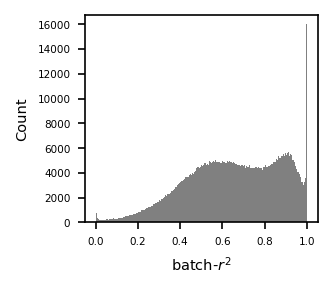

648,609/769,616 (84.3%) motifs evaluated
mean r2 = 0.653
200,593/648,609 (30.9%) has r2 > 0.8


In [20]:
def test():
    utils.hist(r2s_mt_pre, "batch-$r^2$", "Count", bins=200)
    n0 = np.sum(r2s_mt_pre>0.8)
    n1 = np.sum(np.isfinite(r2s_mt_pre))
    n2 = np.sum(mtfilter)
    print(f"{n1:,}/{n2:,} ({n1/n2:.1%}) motifs evaluated")
    print(f"mean r2 = {np.nanmean(r2s_mt_pre):.3f}")
    print(f"{n0:,}/{n1:,} ({n0/n1:.1%}) has r2 > 0.8")
test()

## length

In [21]:
trfilter = np.all(pd.read_csv("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/clinic/analysis/80518_loci.alu.mismap_1.r2.v2.filter.tsv", sep="\t", index_col=0).values[:,3:], axis=1).astype(bool)

In [22]:
def test():
    n0 = np.sum(trfilter[i1i0[:,1]])
    n1 = np.sum(trfilter)
    print(f"{n0:,}/{n1:,} ({n0/n1:.1%}) loci can be evaluated")
test()

38,804/39,125 (99.2%) loci can be evaluated


In [16]:
def test():
    pbed = np.loadtxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/output/pan.tr.mbe.v2.bed", dtype=object, comments=None)
    ntr, ncol = pbed.shape
    nh = (ncol-3) // 4
    ng= nh // 2
    trlens = np.full([ntr, nh], np.nan, dtype=object)
    for tri in range(ntr):
        for hi in range(nh):
            if pbed[tri,3+4*hi] == "None": continue
            trlens[tri,hi] = int(pbed[tri,5+4*hi]) - int(pbed[tri,4+4*hi])
    
    gs = np.loadtxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/input/genomes.HPRC.txt", dtype=object)
    hs = np.array([f"{g}.{h}" for g in gs for h in [0,1]])
    trs = np.array([f"{ch}:{s}-{e}" for ch, s, e in pbed[:,:3]])
    df = pd.DataFrame(trlens, columns=hs, index=trs)
    df.to_csv(f"/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/analysis/trlens.{ntr}x{nh}.txt", sep="\t", na_rep=".")
    
    atrlens = np.full([ntr,ng], np.nan, dtype=object)
    for gi in range(ng):
        atrlens[:,gi] = np.mean(trlens[:,2*gi:2*gi+2], axis=1)
    df = pd.DataFrame(atrlens, columns=gs, index=trs)
    df.to_csv(f"/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/analysis/trlens.{ntr}x{ng}.txt", sep="\t", na_rep=".")
# test()

In [23]:
def test():
    gs = np.loadtxt("/project/mchaisso_100/cmb-16/tsungyul/work/vntr/hapdb/config/genomes.HPRC.notinHGSVC.hasIL.src.txt", usecols=1, dtype=object)
    gs1 = np.loadtxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/input/genomes.HPRC.txt", dtype=object)
    gm1 = np.isin(gs1, gs)
    
    ng = gs.size
    ntr = len(ki_tr)

    trlens_ = pd.read_csv(f"/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hprc/analysis/trlens.81261x48.txt", sep="\t", na_values=".", index_col=0).values    
    trlens = np.full([ntr,ng], np.nan)
    trlens[i1i0[:,1]] = trlens_[i1i0[:,0]][:,gm1]
    return trlens
trlens = test()

In [28]:
def test():
    trdsg = np.zeros_like(trlens)
    for tri in i1i0[:,1]:
        si, ei = get_ki(tri)
        trdsg[tri] = np.sum(ilgt[:,si:ei], axis=1)
    return trdsg
trdsg = test()

38804 TRs scanned
9315 TRs not tested: no variation in length for this TR in HPRC
29,489/38,804 (76.0%) TRs evaluated
mean r2 = 0.521
879/29,489 (3.0%) has r2 > 0.8


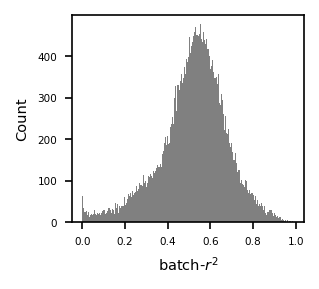

In [29]:
def test():
    nscan, nconst = 0, 0
    ntr = len(ki_tr)
    r2s = np.full(ntr, np.nan)
    for tri in i1i0[:,1]:
        if not trfilter[tri]: continue
        nscan += 1
        xs = trlens[tri]
        m = np.isfinite(xs)
        xs = xs[m]
        xs = np.clip(xs-20, 0, None)
        if not np.any(xs): 
            assert False
            continue
        if np.unique(xs).size == 1:
            nconst += 1
            continue
        ys = trdsg[tri,m]
        r2s[tri] = sm.OLS(np.insert(ys,0,0), sm.add_constant(np.insert(xs,0,0))).fit().rsquared
        
    n0 = np.sum(r2s>0.8)
    n1 = nscan - nconst
    n2 = nscan
    print(f"{nscan} TRs scanned")
    print(f"{nconst} TRs not tested: no variation in length for this TR in HPRC")
    print(f"{n1:,}/{n2:,} ({n1/n2:.1%}) TRs evaluated")
    print(f"mean r2 = {np.nanmean(r2s):.3f}")
    print(f"{n0:,}/{n1:,} ({n0/n1:.1%}) has r2 > 0.8")
    utils.hist(r2s, "batch-$r^2$", "Count", bins=200)
    
    return r2s
r2s_len_pre = test()

In [30]:
np.savetxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/eval/pre_correction.length.r2.txt", r2s_len_pre, fmt="%s")

# batch-$r^2$ after bias correction

In [31]:
def test():
    with open("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/clinic/bias/invariant_kmer/ikmer.ikstats.pickle", 'rb') as f:
        ikmer, ikstats = pickle.load(f)
    return ikmer, ikstats
ikmer, ikstats = test()

In [32]:
def test():
    ng, NCCK = ilgt.shape
    ntr = len(ki_tr)
    
    bias = np.zeros([ng, ntr])
    with open(f"/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/gt_pickle/agt.pickle", 'rb') as f:
        agt = pickle.load(f)
    for tri in range(ntr):
        if tri % 1000 == 0:
            print(".", end="")
        si, ei = get_ki(tri)
        inv = np.nonzero(ikmer[si:ei])[0] + si
        if inv.size:
            bias[:,tri] = np.mean(agt[:,inv] / ikstats[0,inv], axis=1)
    print()
    bias[bias==0] = np.nan
    bias /= np.nanmean(bias, axis=0)
    n0 = np.sum(~np.isfinite(bias))
    print(f"{n0} cells of nan's")
    return bias

bias = test()

.................................................................................
101258 cells of nan's


/tmp/SLURM_10309788/ipykernel_38073/2542290201.py:17: RuntimeWarning: Mean of empty slice
  bias /= np.nanmean(bias, axis=0)


In [33]:
pd.DataFrame(bias)

,0,1,2,3,4,5,6,7,8,9,...,80508,80509,80510,80511,80512,80513,80514,80515,80516,80517
0,0.981737,1.011476,1.040419,0.800176,0.649480,NaN,0.879755,1.105164,NaN,0.783665,...,1.436215,1.244160,1.197738,1.225795,1.286517,1.277591,1.295167,1.264499,1.307669,1.245189
1,1.254699,1.605487,1.594114,1.622086,1.437078,NaN,1.261365,1.366635,NaN,1.298430,...,0.801372,0.617954,0.746019,0.703036,0.624711,0.725505,0.815091,0.717883,0.554855,0.526273
2,1.075996,0.847562,1.158865,1.142244,0.912936,NaN,0.733483,0.838134,NaN,0.866872,...,0.736938,0.652319,0.545208,0.726994,0.883401,0.681843,0.815616,0.599147,0.816795,1.040025
3,0.994156,0.515717,0.714511,0.884344,0.882969,NaN,0.897321,1.204922,NaN,0.796447,...,0.974377,1.107265,0.994281,1.104297,1.201264,1.236286,1.158999,1.056429,1.059394,1.392902
4,0.942243,0.742916,0.954855,1.150061,1.198080,NaN,0.867282,1.025210,NaN,0.859050,...,1.281770,1.409391,1.309794,1.665915,1.313554,1.300500,1.515732,1.350625,0.996649,1.128683
5,1.107413,1.002392,1.112181,0.793713,1.257244,NaN,0.941180,0.669480,NaN,1.246618,...,1.634673,1.169430,1.217272,1.179236,1.083581,1.337967,1.221924,1.171063,1.066563,1.620157
6,0.818472,1.086479,0.906860,0.893373,0.863195,NaN,1.209949,1.192172,NaN,1.189266,...,0.660184,0.585064,0.616826,0.679423,0.622170,0.615007,0.526552,0.704209,0.628259,0.783902
7,1.052617,0.883068,1.027438,0.903922,0.709107,NaN,1.100838,1.001305,NaN,0.925394,...,0.850463,0.745427,0.573984,0.620265,0.613406,0.658787,0.789572,0.690747,0.794279,0.754840
8,1.171366,0.992668,1.072997,1.280671,0.786474,NaN,0.746373,1.235415,NaN,1.196783,...,1.228755,1.162232,1.416501,1.006252,1.603702,1.246761,1.222654,1.120808,1.516335,1.468488
9,0.937525,1.081324,0.787309,0.711699,0.952637,NaN,0.841418,0.855420,NaN,0.706720,...,0.674905,0.705431,0.482166,0.441949,0.492285,0.614902,0.616062,0.711814,0.600359,0.349375


In [34]:
def test():
    with open("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/bias/bias.v1.pickle", 'wb') as f:
        pickle.dump(bias, f)
# test()

In [35]:
def test():
    ntr = len(ccki_tr)
    ilcgt_bc = np.copy(ilcgt)
    for tri in range(ntr):
        si, ei = get_ccki(tri)
        ilcgt_bc[:,si:ei] /= (bias[:,tri][:,None])
    return ilcgt_bc
ilcgt_bc = test()

In [36]:
pd.DataFrame(ilcgt_bc)

,0,1,2,3,4,5,6,7,8,9,...,4456871,4456872,4456873,4456874,4456875,4456876,4456877,4456878,4456879,4456880
0,1.850054,0.960082,3.004728,2.767513,3.138575,0.000000,0.623046,0.000000,0.684493,0.0,...,0.000000,0.244946,0.349923,0.569332,1.238879,0.628482,0.942665,0.343505,0.599357,0.621862
1,1.397350,1.467103,2.814368,2.867703,2.933998,0.000000,0.632947,0.083109,0.103768,0.0,...,0.010492,0.734475,0.545610,1.138663,4.168902,2.182267,2.981814,0.687010,1.992329,2.018092
2,1.930261,0.708037,2.722576,2.916014,2.842524,0.000000,1.116245,0.301949,0.957286,0.0,...,0.000000,0.570346,0.777744,1.138663,2.225315,0.962868,1.637872,0.687010,1.147008,1.202267
3,1.700242,1.130152,2.977930,2.781618,3.043559,0.002507,1.544534,0.427991,0.839090,0.0,...,0.003538,0.413989,0.311377,0.569332,1.173479,0.536727,0.880232,0.343505,0.626897,0.614552
4,2.117602,0.918740,3.185112,2.672574,3.469126,0.000000,1.922321,0.084678,1.271142,0.0,...,0.000000,0.372113,0.265795,0.569332,1.466547,0.781305,1.213930,0.343505,0.732811,0.693371
5,1.871658,0.996286,3.039114,2.749416,3.291832,0.000000,1.636390,0.116885,0.649743,0.0,...,0.000000,0.325162,0.200100,0.569332,1.045307,0.548225,0.775146,0.343505,0.513450,0.490399
6,1.845348,1.078514,2.735864,2.909020,2.883834,0.000000,0.851436,0.070812,0.603106,0.0,...,0.000000,0.825133,0.644006,1.138663,2.767763,1.408051,2.055003,0.687010,1.417410,1.337861
7,2.250857,0.508300,3.054492,2.741322,3.209754,0.000000,1.245684,0.130500,1.088141,0.0,...,0.000000,0.667338,0.583921,1.138663,2.437498,1.059702,1.755692,0.687010,1.190817,1.145017
8,1.824458,1.037753,2.897010,2.824207,2.745160,0.000000,0.912726,0.089459,0.467397,0.0,...,0.000000,0.402328,0.272765,0.569332,1.614379,0.770284,1.160631,0.343505,0.801512,0.835342
9,1.587925,1.216089,3.030621,2.753885,3.130410,0.000000,0.829874,0.107022,0.807914,0.0,...,0.000000,0.516338,0.379351,1.138663,3.883948,2.010514,2.612069,0.687010,1.408370,1.996623


In [37]:
def test():
    with open("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/gt_pickle/acgt_bc.pickle", 'wb') as f:
        pickle.dump(ilcgt_bc, f, protocol=pickle.HIGHEST_PROTOCOL)
# test()

In [9]:
def test():
    with open("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/gt_pickle/acgt_bc.pickle", 'rb') as f:
        return pickle.load(f)
ilcgt_bc = test()

In [38]:
def test():
    ntr = len(ki_tr)
    ilgt_bc = np.copy(ilgt)
    for tri in range(ntr):
        si, ei = get_ki(tri)
        ilgt_bc[:,si:ei] /= (bias[:,tri][:,None])
    return ilgt_bc
ilgt_bc = test()

In [39]:
pd.DataFrame(ilgt_bc)

,0,1,2,3,4,5,6,7,8,9,...,62457721,62457722,62457723,62457724,62457725,62457726,62457727,62457728,62457729,62457730
0,1.892979,1.923026,1.953073,1.051655,3.004728,2.704256,1.772790,2.764350,0.841324,1.021608,...,2.558520,1.895200,1.279260,2.558520,2.416380,2.392690,1.231880,1.824130,1.302950,2.558520
1,1.464816,1.488829,1.488829,1.488829,2.809565,2.857592,1.368763,2.881605,1.464816,1.488829,...,4.122060,3.091545,2.175532,4.064809,4.236562,4.236562,2.003779,3.091545,2.118281,4.064809
2,1.934386,1.934386,2.021000,0.692914,2.742786,2.800529,1.905514,2.887143,0.692914,0.692914,...,2.240250,1.583110,0.925970,2.150640,2.180510,2.210380,1.194800,1.642850,0.985710,2.180510
3,1.744646,1.744646,1.714566,1.203204,3.008010,2.647049,1.714566,2.767369,1.052803,1.203204,...,2.297190,1.781932,1.094922,2.318659,2.361597,2.361597,1.223737,1.781932,1.051984,2.297190
4,2.042129,2.042129,2.011650,0.883907,3.139393,2.590761,2.194527,2.743159,0.883907,0.944866,...,2.977043,2.493592,1.577578,3.078822,2.824374,2.849819,1.424910,2.468147,1.501244,3.078822
5,1.904405,1.904405,1.904405,1.005103,2.962408,2.697908,1.798605,2.777258,1.058003,1.005103,...,2.115268,1.500574,1.084753,2.115268,2.151426,2.061030,0.976277,1.518654,1.120911,2.115268
6,1.870085,1.904716,1.904716,1.212092,2.735864,2.839758,1.904716,2.909020,1.004305,1.108198,...,2.856515,2.061030,1.410178,2.748040,2.711881,2.711881,1.337862,1.988713,1.410178,2.820357
7,2.244340,2.271710,2.271710,0.574770,3.038070,2.654890,2.216970,2.737000,0.465290,0.547400,...,2.480869,1.755692,0.954181,2.442702,2.442702,2.442702,1.145017,1.793859,1.183184,2.480869
8,1.853042,1.853042,1.879142,1.148364,2.870911,2.870911,1.748646,2.792613,0.991769,1.148364,...,3.268502,2.352489,1.540568,3.247684,3.206047,3.164410,1.665479,2.310852,1.540568,3.247684
9,1.536112,1.536112,1.536112,1.216089,3.104227,2.688196,1.632119,2.816206,1.248091,1.216089,...,4.207936,2.576287,1.889277,3.950307,3.692679,3.606802,1.975154,2.662164,2.146906,3.950307


In [40]:
def test():
    with open("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/gt_pickle/agt_bc.pickle", 'wb') as f:
        pickle.dump(ilgt_bc, f, protocol=pickle.HIGHEST_PROTOCOL)
# test()

In [9]:
def test():
    with open("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/gt_pickle/agt_bc.pickle", 'rb') as f:
        return pickle.load(f)
ilgt_bc = test()

## motif

In [41]:
def test():
    NCCK = mtfilter.size
    nnull = 0
    nconst = 0
    ndrop = 0
    r2s = np.full(NCCK, np.nan)
    ntr = len(ccki_tr)
    for tri in range(ntr):
        gm = trgmask[tri]
        si, ei = get_ccki(tri)
        km = mtfilter[si:ei]
        Xs = pbcgt[:,si:ei][gm][:,km]
        Ys = ilcgt_bc[:,si:ei][gm][:,km]
        for i1, ki in enumerate(np.nonzero(km)[0] + si):
            xs = Xs[:,i1]
            if not np.any(xs): 
                nnull += 1
                continue
            if np.unique(xs).size == 1:
                nconst += 1
                continue
            ys = Ys[:,i1]
            if not np.any(np.isfinite(ys)):
                ndrop += 1
            r2s[ki] = sm.OLS(np.insert(ys,0,0), sm.add_constant(np.insert(xs,0,0))).fit().rsquared
    print(f"{nnull} motifs not tested: not found in HPRC")
    print(f"{nconst} motifs not tested: no variation for this motif in HPRC")
    print(f"{ndrop} motifs dropped during bias correction")
    return r2s
r2s_mt_post = test()

/home1/tsungyul/.conda/envs/nb/envs/nb1/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


42185 motifs not tested: not found in HPRC
78631 motifs not tested: no variation for this motif in HPRC
56393 motifs dropped during bias correction


In [42]:
np.savetxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/eval/post_correction.motif.r2.txt", r2s_mt_post, fmt="%s")

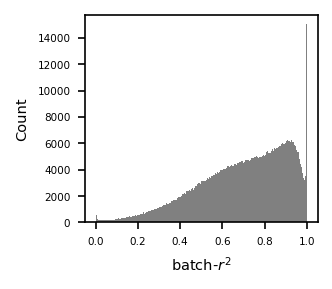

590,873/769,616 (76.8%) motifs evaluated
mean r2 = 0.697
226,268/590,873 (38.3%) has r2 > 0.8


In [43]:
def test():
    utils.hist(r2s_mt_post, "batch-$r^2$", "Count", bins=200)
    n0 = np.sum(r2s_mt_post>0.8)
    n1 = np.sum(np.isfinite(r2s_mt_post))
    n2 = np.sum(mtfilter)
    print(f"{n1:,}/{n2:,} ({n1/n2:.1%}) motifs evaluated")
    print(f"mean r2 = {np.nanmean(r2s_mt_post):.3f}")
    print(f"{n0:,}/{n1:,} ({n0/n1:.1%}) has r2 > 0.8")
test()

## length

In [44]:
def test():
    trdsg_bc = np.zeros_like(trlens)
    for tri in i1i0[:,1]:
        si, ei = get_ki(tri)
        trdsg_bc[tri] = np.sum(ilgt_bc[:,si:ei], axis=1)
    return trdsg_bc
trdsg_bc = test()

38804 TRs scanned
9290 TRs not tested: no variation in length for this TR in HPRC
2015 TRs dropped during bias correction
29,514/38,804 (76.1%) TRs evaluated
mean r2 = 0.795
16,980/29,514 (57.5%) has r2 > 0.8


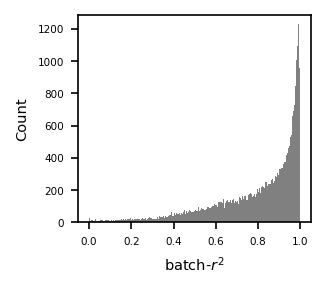

In [45]:
def test():
    nscan, nconst, ndrop = 0, 0, 0
    ntr = len(ki_tr)
    r2s = np.full(ntr, np.nan)
    for tri in i1i0[:,1]:
        if not trfilter[tri]: continue
        nscan += 1
        xs = trlens[tri]
        ys = trdsg_bc[tri]
        if not np.any(np.isfinite(ys)):
            ndrop += 1
            continue
        m = np.isfinite(xs) & np.isfinite(ys)
        xs = xs[m]
        xs = np.clip(xs-20, 0, None)
        if not np.any(xs): 
            assert False
            continue
        if np.unique(xs).size == 1:
            nconst += 1
            continue
        ys = ys[m]
        r2s[tri] = sm.OLS(np.insert(ys,0,0), sm.add_constant(np.insert(xs,0,0))).fit().rsquared
        assert np.isfinite(r2s[tri]), print(tri, r2s[tri])
        
    n0 = np.sum(r2s>0.8)
    n1 = nscan - nconst
    n2 = nscan
    print(f"{nscan} TRs scanned")
    print(f"{nconst} TRs not tested: no variation in length for this TR in HPRC")
    print(f"{ndrop} TRs dropped during bias correction")
    print(f"{n1:,}/{n2:,} ({n1/n2:.1%}) TRs evaluated")
    print(f"mean r2 = {np.nanmean(r2s):.3f}")
    print(f"{n0:,}/{n1:,} ({n0/n1:.1%}) has r2 > 0.8")
    utils.hist(r2s, "batch-$r^2$", "Count", bins=200)
    
    return r2s
r2s_len_post = test()

In [46]:
np.savetxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/eval/post_correction.length.r2.txt", r2s_len_post, fmt="%s")

# Summary

590,873/769,616 (76.8%) motifs evaluated
0.653 -> 0.697


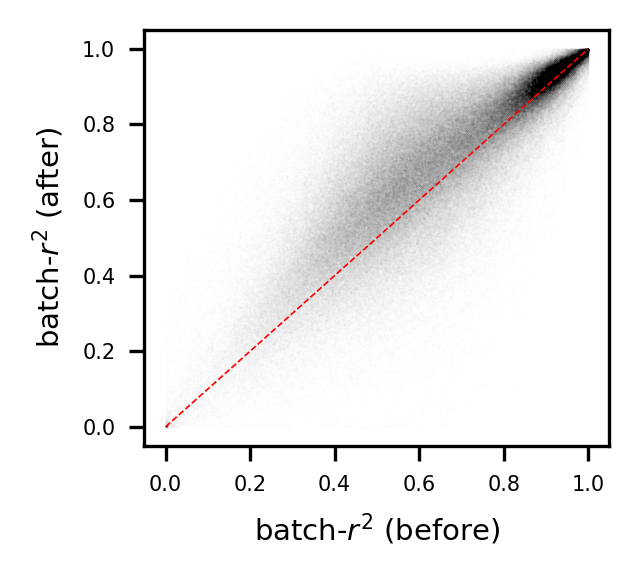

/tmp/SLURM_10309788/ipykernel_38073/1067717497.py:21: RuntimeWarning: Mean of empty slice
  r20tr[tri] = np.nanmean(r20[si:ei])
/tmp/SLURM_10309788/ipykernel_38073/1067717497.py:22: RuntimeWarning: Mean of empty slice
  r21tr[tri] = np.nanmean(r21[si:ei])


32,076/39,125 (82.0%) loci evaluated
0.643 -> 0.719


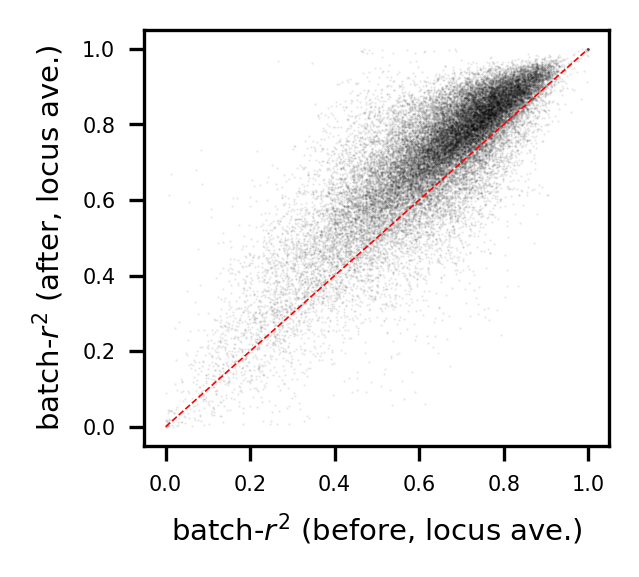

In [47]:
def test():
    r20 = np.loadtxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/eval/pre_correction.motif.r2.txt")
    r21 = np.loadtxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/eval/post_correction.motif.r2.txt")
    n0 = np.sum(np.isfinite(r21))
    n1 = np.sum(mtfilter)
    print(f"{n0:,}/{n1:,} ({n0/n1:.1%}) motifs evaluated")
    print(f"{np.nanmean(r20):.3f} -> {np.nanmean(r21):.3f}")
    xl = [np.nanmin(r20), np.nanmax(r20)]
    plt.figure(dpi=300, figsize=(2,1.8))
    plt.plot(r20, r21, '.k', mew=0, markersize=1, alpha=0.002)
    plt.plot(xl, xl, '--r', lw=0.4)
    plt.xlabel("batch-$r^2$ (before)")
    plt.ylabel("batch-$r^2$ (after)")
    plt.show(); plt.close()
    
    ntr = len(ccki_tr)
    r20tr = np.full(ntr, np.nan)
    r21tr = np.full(ntr, np.nan)
    for tri in range(ntr):
        si, ei = get_ccki(tri)
        r20tr[tri] = np.nanmean(r20[si:ei])
        r21tr[tri] = np.nanmean(r21[si:ei])
    n0 = np.sum(np.isfinite(r21tr))
    n1 = np.sum(trfilter)
    print(f"{n0:,}/{n1:,} ({n0/n1:.1%}) loci evaluated")
    print(f"{np.nanmean(r20tr):.3f} -> {np.nanmean(r21tr):.3f}")
    xl = [np.nanmin(r20tr), np.nanmax(r20tr)]
    plt.figure(dpi=300, figsize=(2,1.8))
    plt.plot(r20tr, r21tr, '.k', mew=0, markersize=1, alpha=0.1)
    plt.plot(xl, xl, '--r', lw=0.4)
    plt.xlabel("batch-$r^2$ (before, locus ave.)")
    plt.ylabel("batch-$r^2$ (after, locus ave.)")
    plt.show(); plt.close()

test()

27,499/39,125 (70.3%) loci evaluated
0.521 -> 0.795


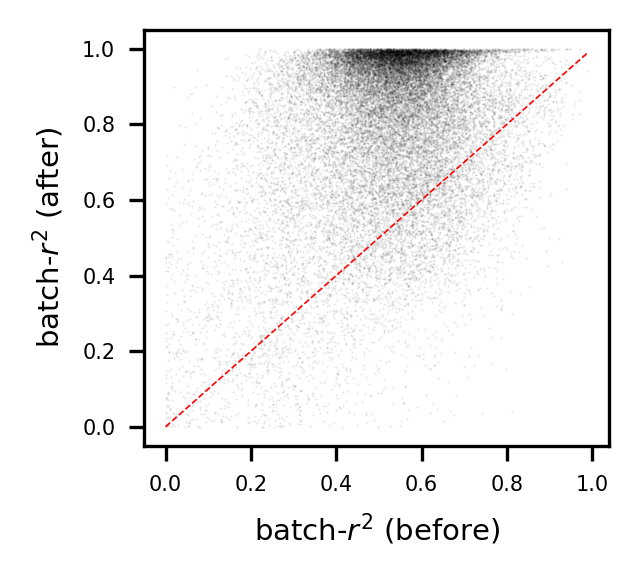

In [48]:
# allow y == 0
def test():
    r20 = np.loadtxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/eval/pre_correction.length.r2.txt")
    r21 = np.loadtxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/eval/post_correction.length.r2.txt")
    
    n0 = np.sum(np.isfinite(r21))
    n1 = np.sum(trfilter)
    print(f"{n0:,}/{n1:,} ({n0/n1:.1%}) loci evaluated")
    print(f"{np.nanmean(r20):.3f} -> {np.nanmean(r21):.3f}")
    xl = [np.nanmin(r20), np.nanmax(r20)]
    plt.figure(dpi=300, figsize=(2,1.8))
    plt.plot(r20, r21, '.k', mew=0, markersize=1, alpha=0.1)
    plt.plot(xl, xl, '--r', lw=0.4)
    plt.xlabel("batch-$r^2$ (before)")
    plt.ylabel("batch-$r^2$ (after)")
    plt.show(); plt.close()
test()


26,547/39,125 (67.9%) VNTRs evaluated
mean r2 = 0.820 / 0.795 in HGSVC / HPRC


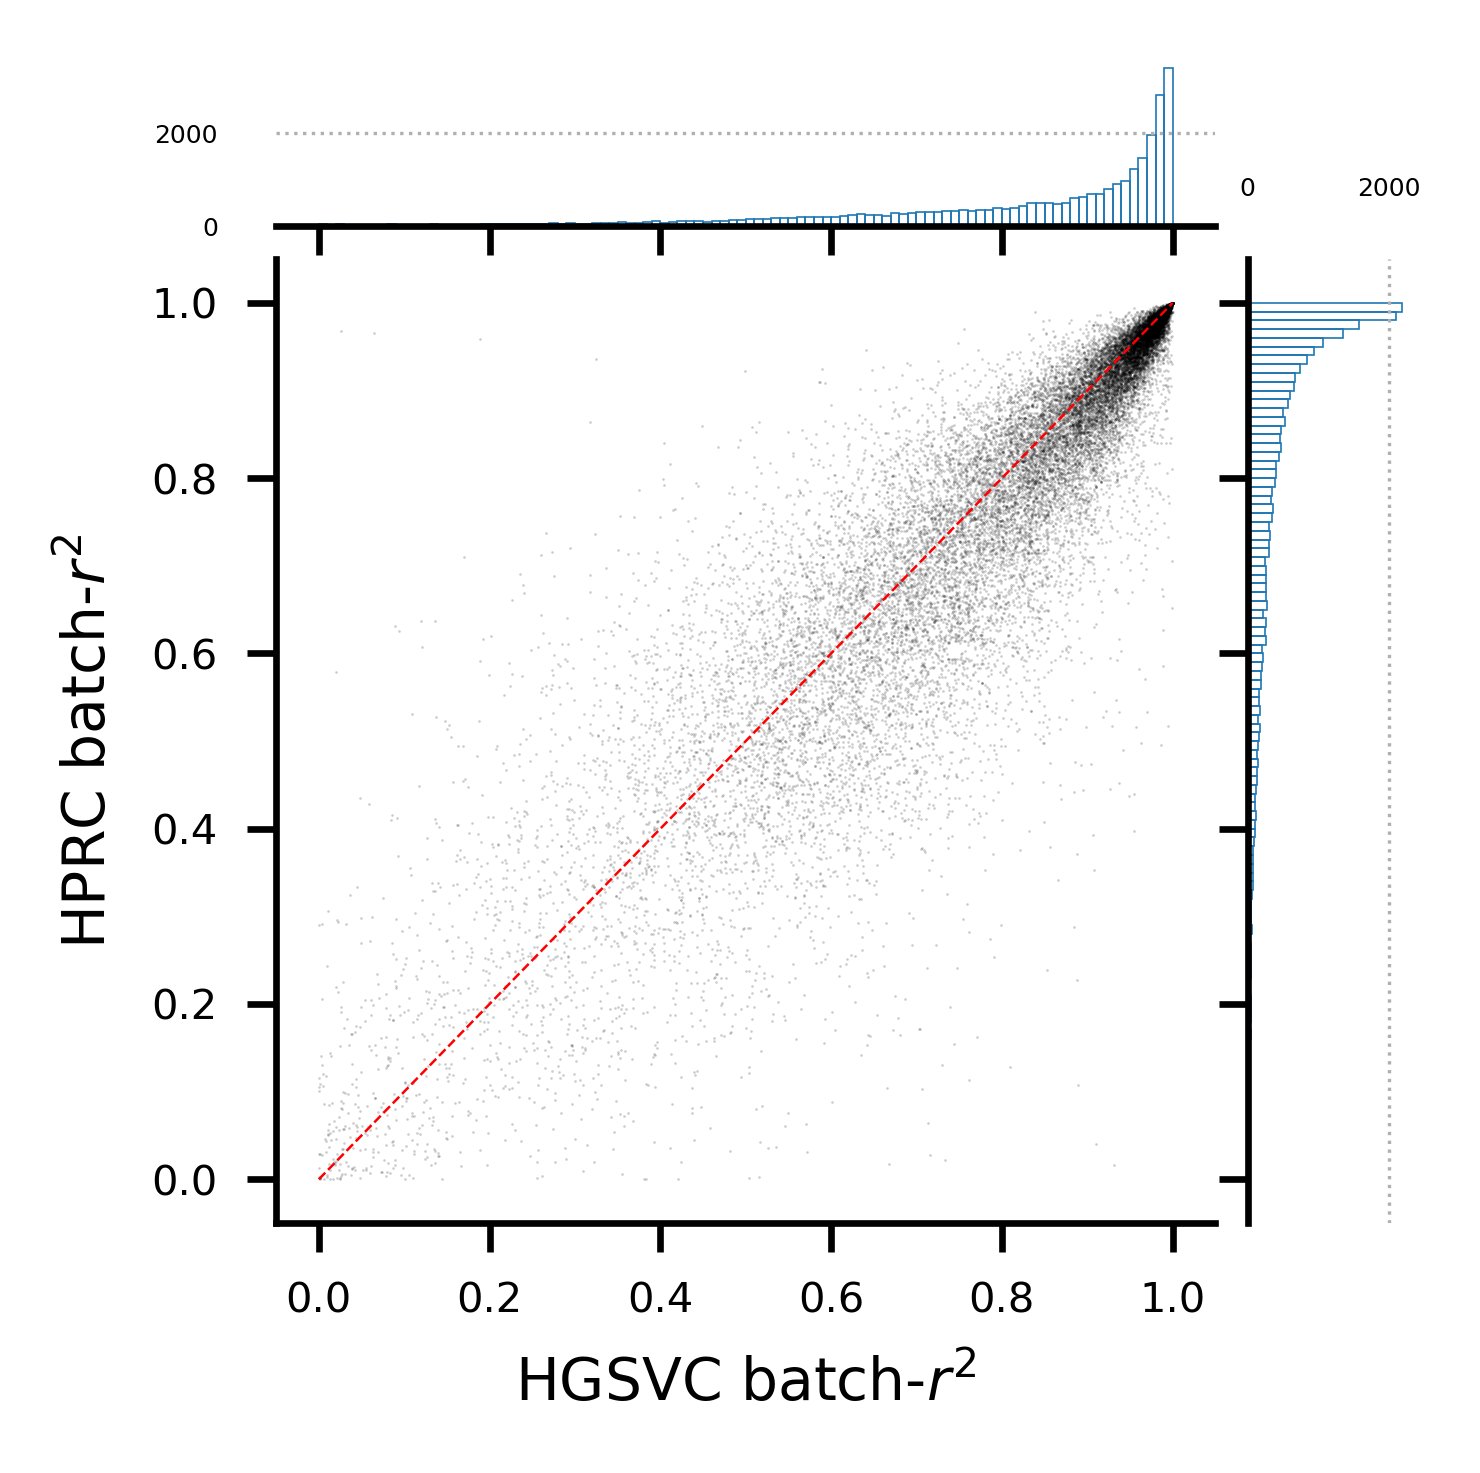

In [70]:
def test():
    r2hgsvc = np.loadtxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/clinic/bias/invariant_kmer/output2/R2_all_loci.R2a_all_loci.txt", usecols=1)
    r2hprc = np.loadtxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/eval/post_correction.length.r2.txt")
    
    df = pd.DataFrame(r2hgsvc, columns=["HGSVC batch-$r^2$"])
    df["HPRC batch-$r^2$"] = r2hprc
    
    n0 = np.sum((np.isfinite(r2hgsvc) & np.isfinite(r2hprc))[trfilter])
    n1 = r2hgsvc[trfilter].size
    print(f"{n0:,}/{n1:,} ({n0/n1:.1%}) VNTRs evaluated")
    print(f"mean r2 = {np.nanmean(r2hgsvc):.3f} / {np.nanmean(r2hprc):.3f} in HGSVC / HPRC")

    gr = sns.JointGrid(data=df, y="HPRC batch-$r^2$", x="HGSVC batch-$r^2$", height=2.5)
    gr.fig.set(dpi=600)
    gr.plot_joint(sns.scatterplot, s=.1, alpha=.2, color='k', linewidth=0)
    xmin, xmax = gr.ax_joint.get_xlim()
    ymin, ymax = gr.ax_joint.get_ylim()
    js = [min(xmin, ymin), max(xmax, ymax)]
    gr.ax_joint.set_xlim(js)
    gr.ax_joint.set_ylim(js)
    ds = [min(np.nanmin(r2hgsvc),np.nanmin(r2hprc)), max(np.nanmax(r2hgsvc),np.nanmax(r2hprc))]
    gr.ax_joint.plot(ds, ds, '--r', lw=0.3)
    gr.plot_marginals(sns.histplot, bins=100, fill=False, linewidth=0.2)
    
    gr.ax_marg_y.grid(True, axis='x', ls=':', lw=0.4)
    gr.ax_marg_y.tick_params(labeltop=True, labelsize=3)
    gr.ax_marg_x.grid(True, axis='y', ls=':', lw=0.4)
    gr.ax_marg_x.tick_params(labelleft=True, labelsize=3)
    
    
test()

581,108/769,616 (75.5%) motifs evaluated
mean r2 = 0.701 / 0.697 in HGSVC / HPRC


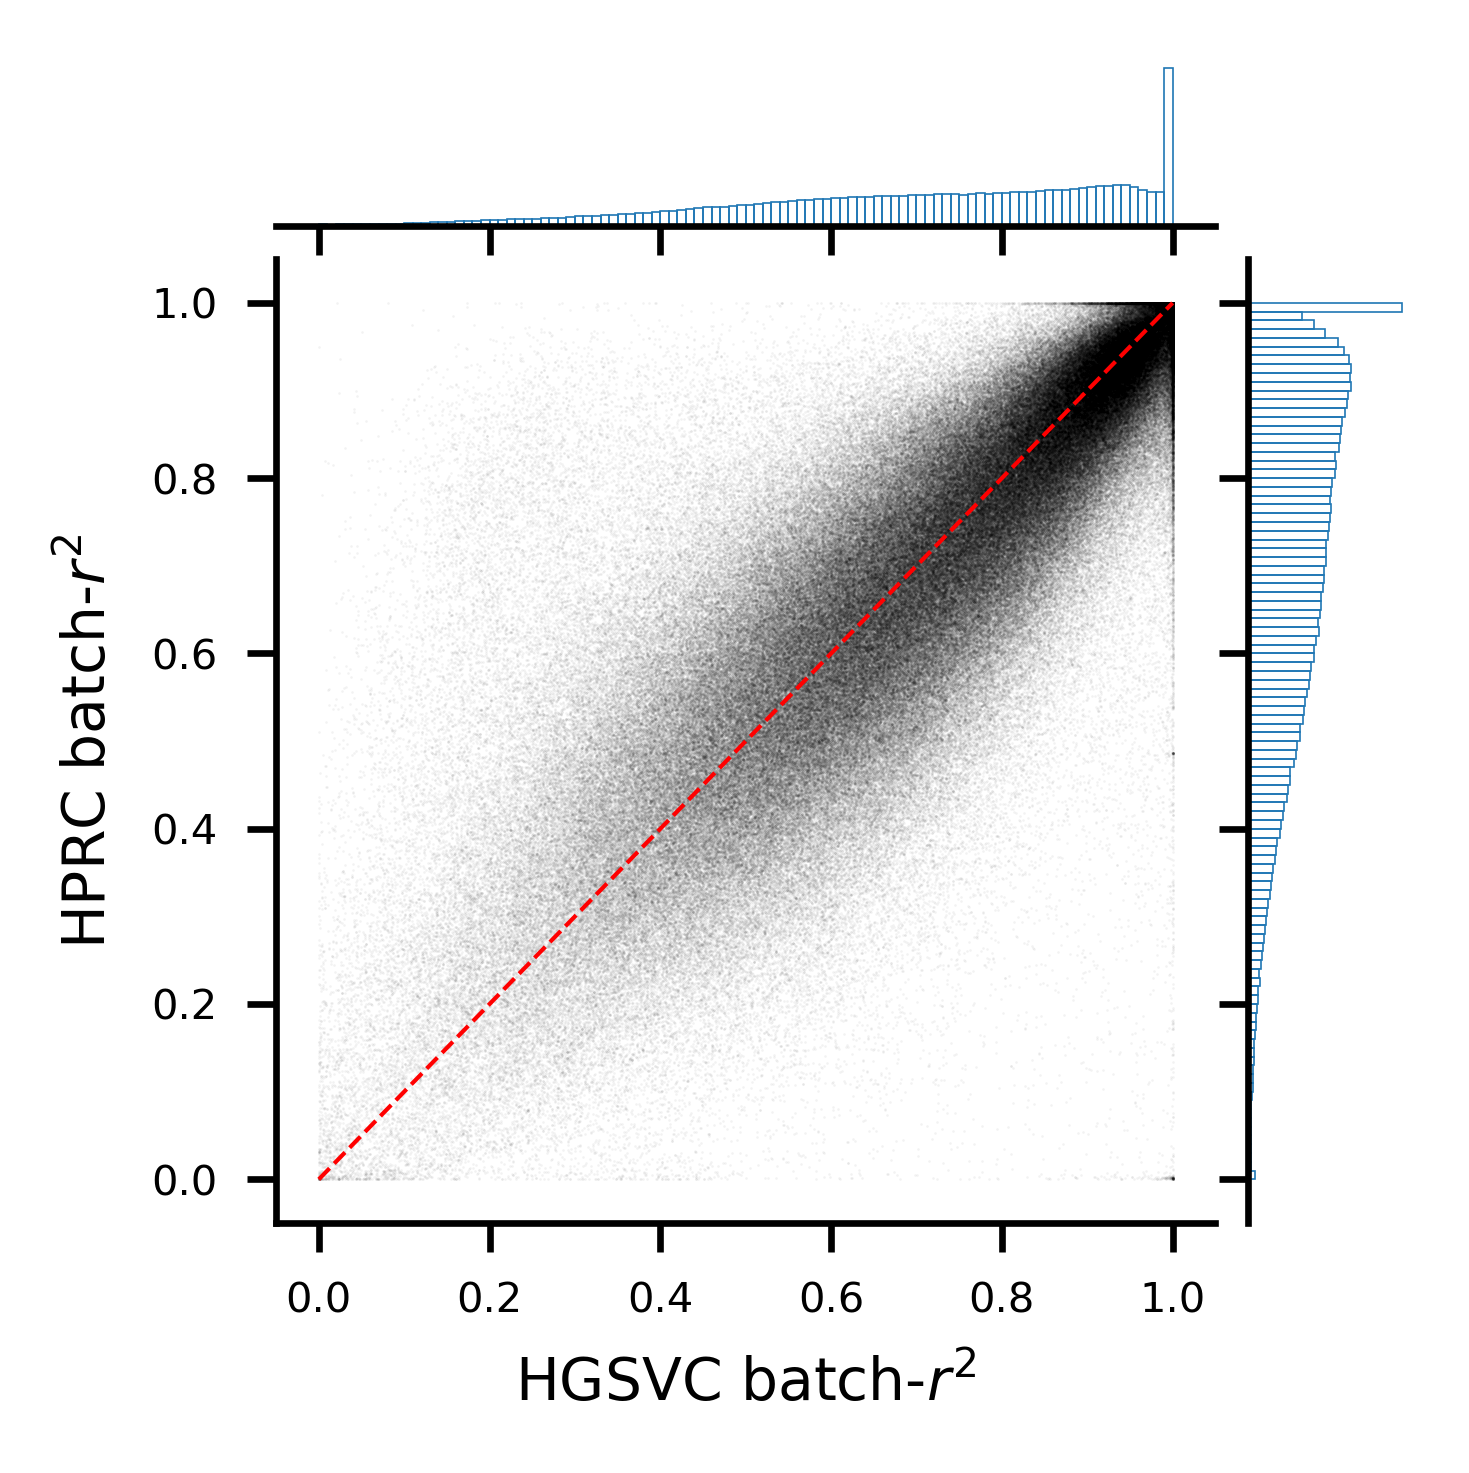

In [64]:
def test():
    r2hprc = np.loadtxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/eval/post_correction.motif.r2.txt")
    with open(f"/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/clinic/bias/invariant_kmer/output2/R2_all_mtf.R2a_all_mtf.pickle", 'rb') as f:
        _, r2hgsvc = pickle.load(f)
    df = pd.DataFrame(r2hgsvc, columns=["HGSVC batch-$r^2$"])
    df["HPRC batch-$r^2$"] = r2hprc
    
    n0 = np.sum((np.isfinite(r2hgsvc) & np.isfinite(r2hprc))[mtfilter])
    n1 = r2hgsvc[mtfilter].size
    print(f"{n0:,}/{n1:,} ({n0/n1:.1%}) motifs evaluated")
    print(f"mean r2 = {np.nanmean(r2hgsvc):.3f} / {np.nanmean(r2hprc):.3f} in HGSVC / HPRC")

    gr = sns.JointGrid(data=df, y="HPRC batch-$r^2$", x="HGSVC batch-$r^2$", height=2.5)
    gr.fig.set(dpi=600)
    gr.plot_joint(sns.scatterplot, s=.1, alpha=.05, color='k', linewidth=0)
    xmin, xmax = gr.ax_joint.get_xlim()
    ymin, ymax = gr.ax_joint.get_ylim()
    js = [min(xmin, ymin), max(xmax, ymax)]
    gr.ax_joint.set_xlim(js)
    gr.ax_joint.set_ylim(js)
    ds = [min(np.nanmin(r2hgsvc),np.nanmin(r2hprc)), max(np.nanmax(r2hgsvc),np.nanmax(r2hprc))]
    gr.ax_joint.plot(ds, ds, '--r', lw=0.5)
    gr.plot_marginals(sns.histplot, bins=100, fill=False, linewidth=0.2)
test()

## eMotifs

23,901/25,031 (95.5%) eMotifs evaluated
mean r2 = 0.842 / 0.835 in HGSVC / HPRC


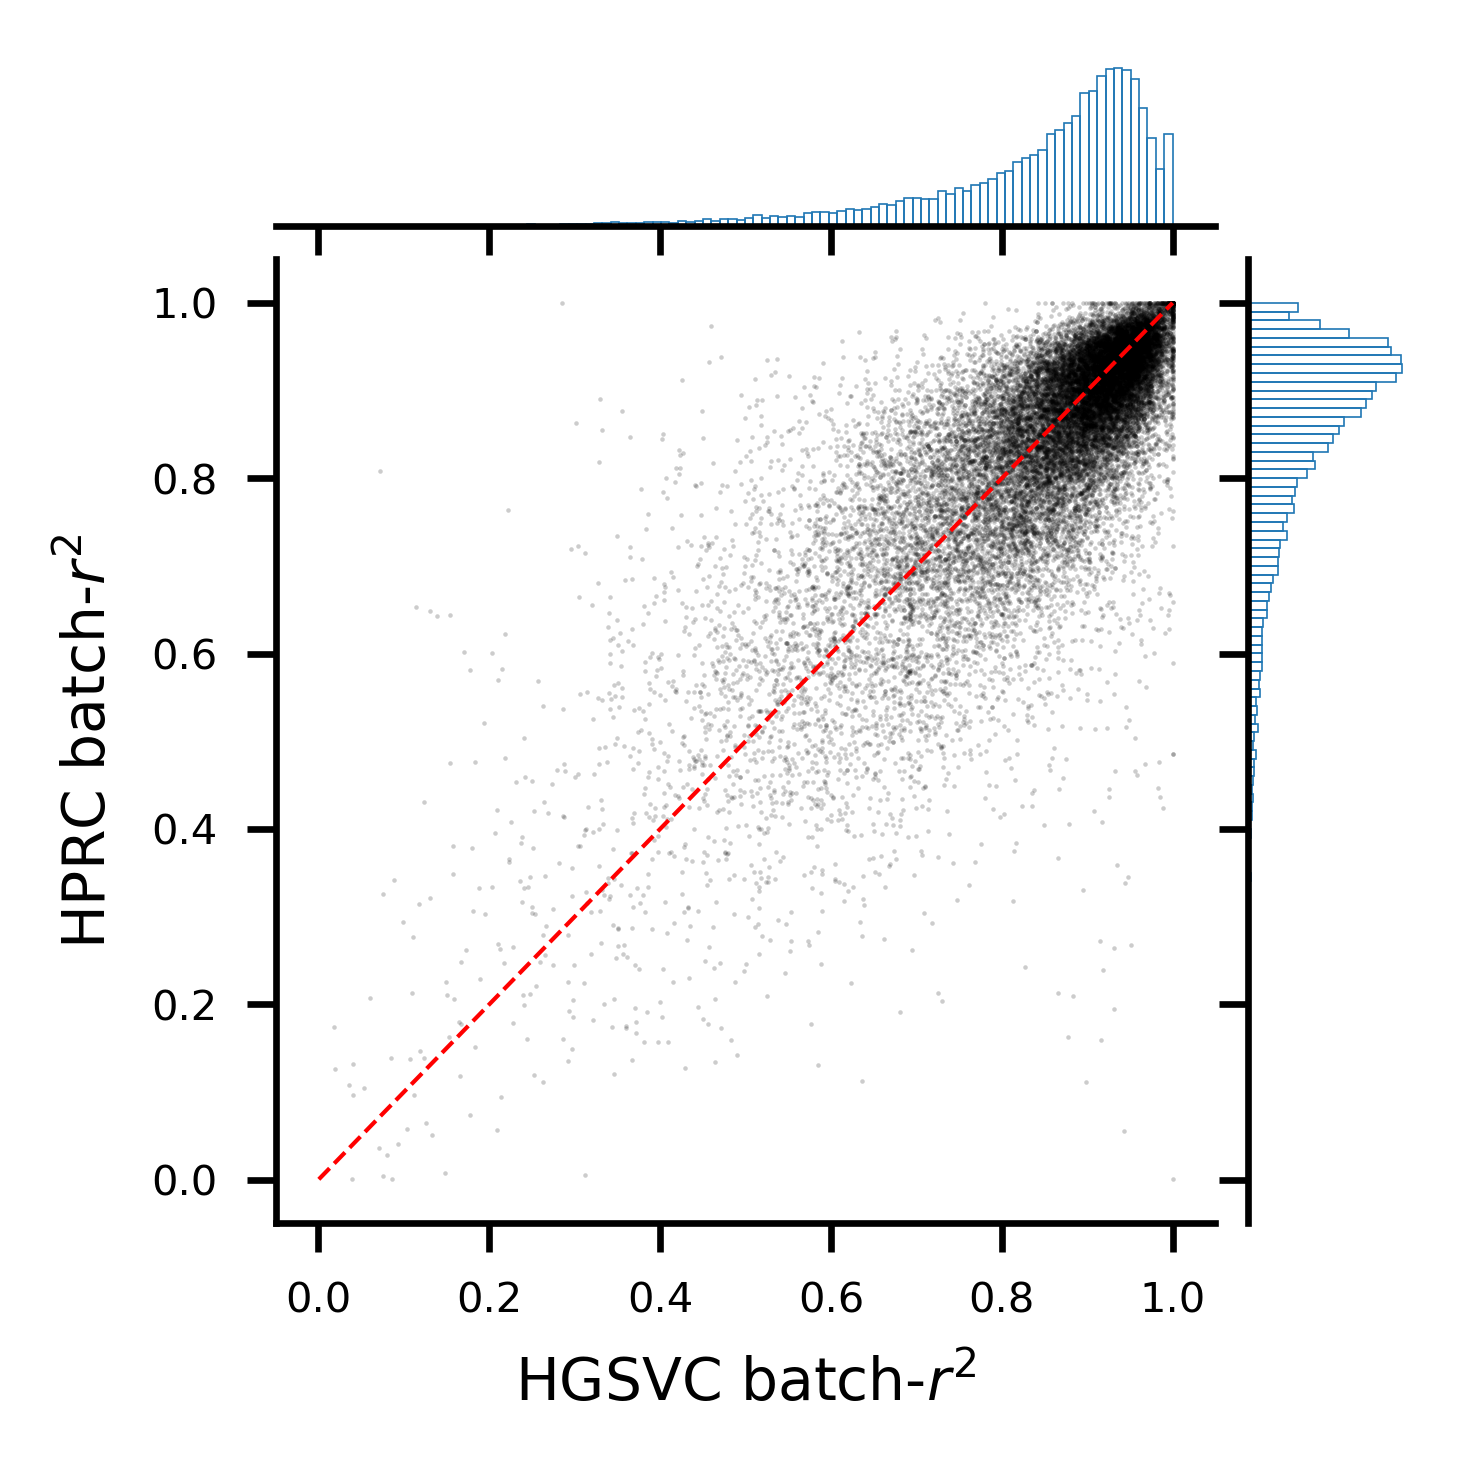

In [60]:
def test():
    df = pd.read_csv("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/gtex/emotif/analysis10/Alltissue.egenes.tsv", sep="\t", index_col=0)
    kis = np.sort(list(set(df["lead_ki"])))
    r2hprc = np.loadtxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/eval/post_correction.motif.r2.txt")[kis]
    
    with open(f"/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/clinic/bias/invariant_kmer/output2/R2_all_mtf.R2a_all_mtf.pickle", 'rb') as f:
        _, r2hgsvc = pickle.load(f)
    r2hgsvc = r2hgsvc[kis]
    df = pd.DataFrame(r2hgsvc, columns=["HGSVC batch-$r^2$"])
    df["HPRC batch-$r^2$"] = r2hprc
    
    n0 = np.sum(np.isfinite(r2hgsvc) & np.isfinite(r2hprc))
    n1 = r2hgsvc.size
    print(f"{n0:,}/{n1:,} ({n0/n1:.1%}) eMotifs evaluated")
    print(f"mean r2 = {np.nanmean(r2hgsvc):.3f} / {np.nanmean(r2hprc):.3f} in HGSVC / HPRC")

    gr = sns.JointGrid(data=df, y="HPRC batch-$r^2$", x="HGSVC batch-$r^2$", height=2.5)
    gr.fig.set(dpi=600)
    gr.plot_joint(sns.scatterplot, s=0.3, alpha=.2, color='k', linewidth=0)
    xmin, xmax = gr.ax_joint.get_xlim()
    ymin, ymax = gr.ax_joint.get_ylim()
    js = [min(xmin, ymin), max(xmax, ymax)]
    gr.ax_joint.set_xlim(js)
    gr.ax_joint.set_ylim(js)
    ds = [min(min(r2hgsvc),min(r2hprc)), max(max(r2hgsvc),max(r2hprc))]
    gr.ax_joint.plot(ds, ds, '--r', lw=0.5)
    gr.plot_marginals(sns.histplot, bins=100, fill=False, linewidth=0.2)
    
    
test()

## likely causal motifs

198/206 (96.1%) likely causal motifs evaluated
mean r2 = 0.857 / 0.851 in HGSVC / HPRC


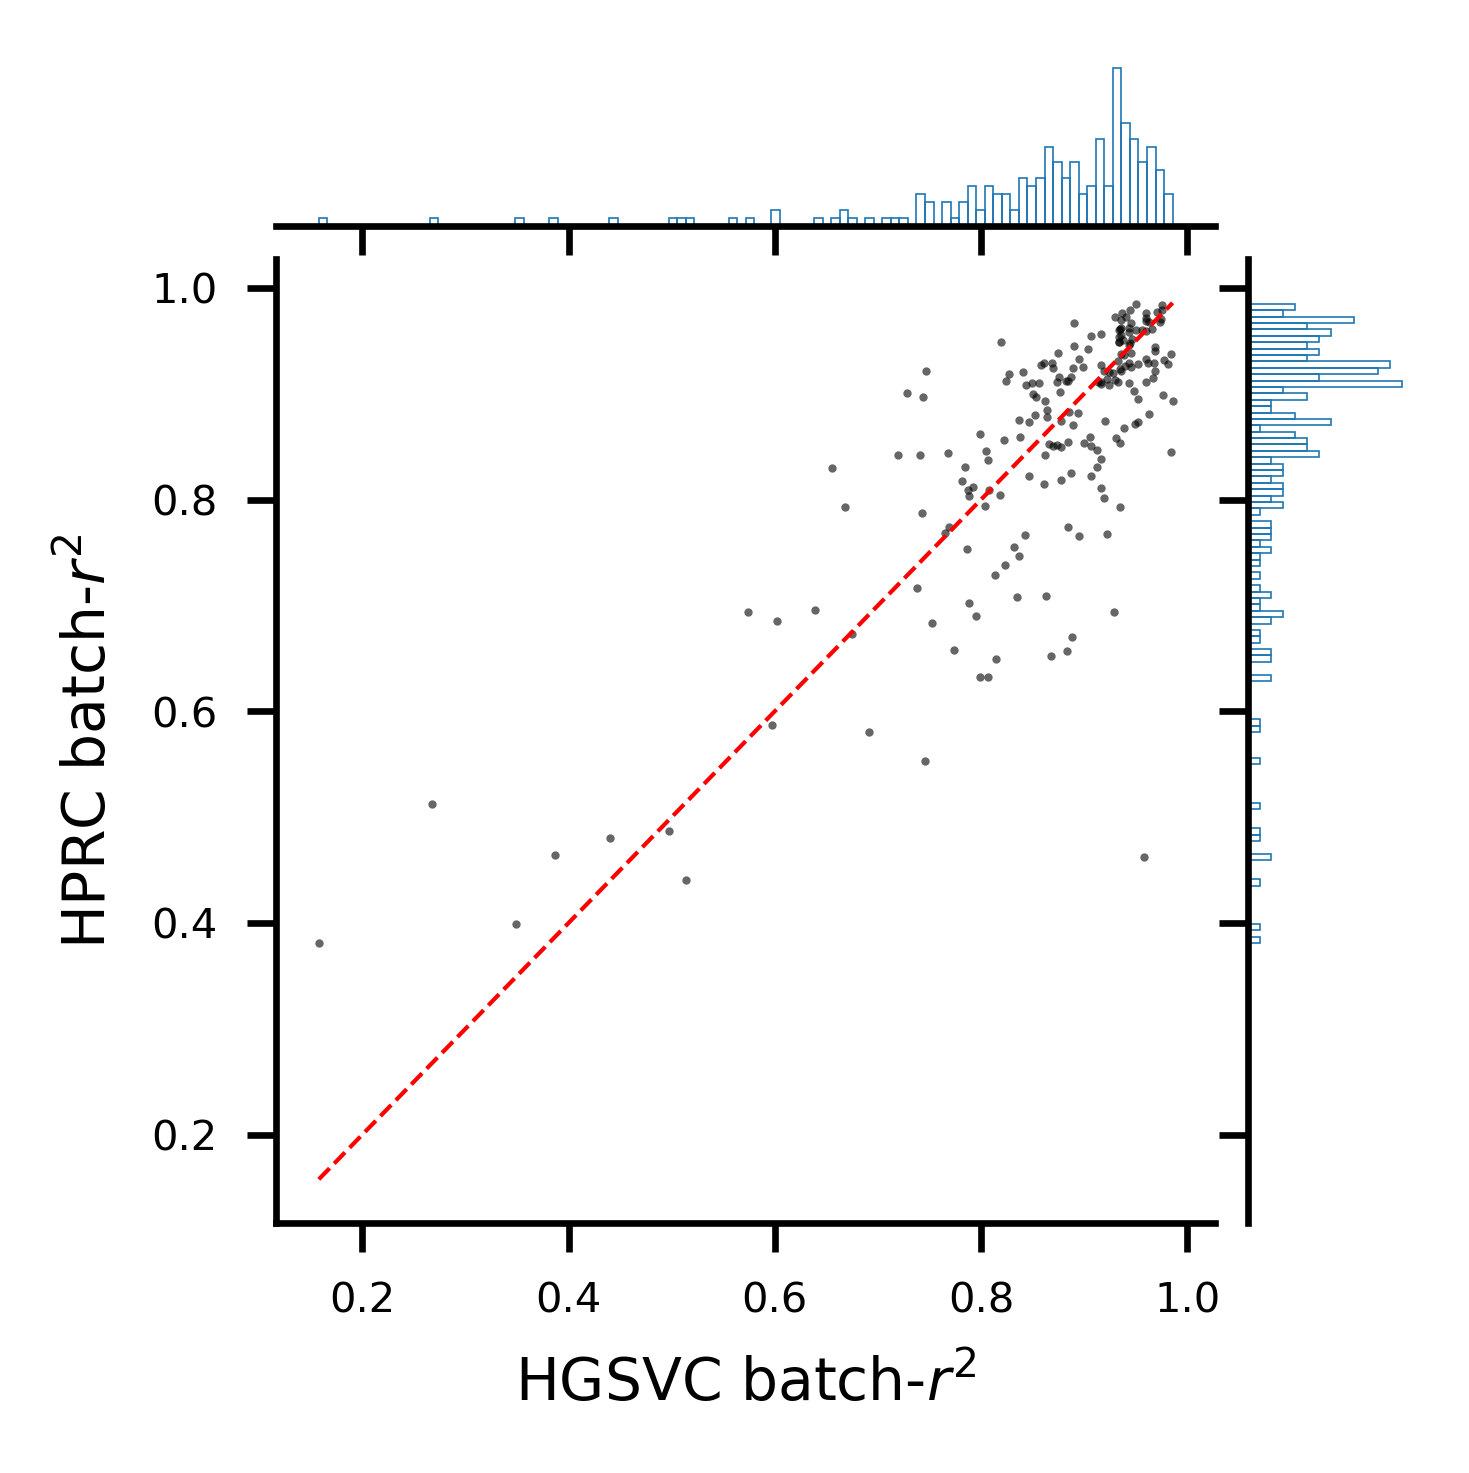

In [59]:
def test():
    df = pd.read_csv("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/gtex/susieR/analysis10/Alltissue.egenes.finemap.validated.tsv", sep="\t", index_col=0)
    kis = set()
    for kistr in df["ki"]:
        for ki in kistr.split(","):
            if ki == "-1": continue
            kis.add(int(ki))
    kis = np.sort(list(kis))
    r2hprc = np.loadtxt("/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/1kgr/hprc/eval/post_correction.motif.r2.txt")[kis]
    
    
    with open(f"/project/mchaisso_100/cmb-17/vntr_genotyping/rpgg2_k21_84k/hgsvc/clinic/bias/invariant_kmer/output2/R2_all_mtf.R2a_all_mtf.pickle", 'rb') as f:
        _, r2hgsvc = pickle.load(f)
    r2hgsvc = r2hgsvc[kis]
    df = pd.DataFrame(r2hgsvc, columns=["HGSVC batch-$r^2$"])
    df["HPRC batch-$r^2$"] = r2hprc
    
    n0 = np.sum(np.isfinite(r2hgsvc) & np.isfinite(r2hprc))
    n1 = r2hgsvc.size
    print(f"{n0:,}/{n1:,} ({n0/n1:.1%}) likely causal motifs evaluated")
    print(f"mean r2 = {np.nanmean(r2hgsvc):.3f} / {np.nanmean(r2hprc):.3f} in HGSVC / HPRC")

    # dmin = min(min(r2hgsvc), min(r2hprc)) - 0.03
    # dmax = max(max(r2hgsvc), max(r2hprc)) + 0.03
    
    gr = sns.JointGrid(data=df, y="HPRC batch-$r^2$", x="HGSVC batch-$r^2$", height=2.5)
    gr.fig.set(dpi=600)
    gr.plot_joint(sns.scatterplot, s=1, alpha=0.6, color='k', linewidth=0)
    xmin, xmax = gr.ax_joint.get_xlim()
    ymin, ymax = gr.ax_joint.get_ylim()
    js = [min(xmin, ymin), max(xmax, ymax)]
    gr.ax_joint.set_xlim(js)
    gr.ax_joint.set_ylim(js)
    ds = [min(min(r2hgsvc),min(r2hprc)), max(max(r2hgsvc),max(r2hprc))]
    gr.ax_joint.plot(ds, ds, '--r', lw=0.5)
    gr.plot_marginals(sns.histplot, bins=100, fill=False, linewidth=0.2)    
    
test()